In [1]:
!pip install geopandas

In [13]:
import pandas as pd
import requests

# Download HUD crosswalk file (FIPS to county name/state)
url = "https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt"

# This file has format: state_abbr | state_fips | county_fips | county_name | class
df_lookup = pd.read_csv(url, header=None, dtype=str)
df_lookup.columns = ["state_abbr", "state_fips", "county_fips3", "county_name", "class"]

# Build 5-digit FIPS code
df_lookup["county_fips"] = df_lookup["state_fips"].str.zfill(2) + df_lookup["county_fips3"].str.zfill(3)
df_lookup = df_lookup[["county_fips", "county_name", "state_abbr"]]

# Save once for reuse
import os
os.makedirs("data", exist_ok=True)
df_lookup.to_csv("data/fips_lookup.csv", index=False)

print("Saved FIPS lookup to data/fips_lookup.csv")
df_lookup.head()


Saved FIPS lookup to data/fips_lookup.csv


,county_fips,county_name,state_abbr
0,01001,Autauga County,AL
1,01003,Baldwin County,AL
2,01005,Barbour County,AL
3,01007,Bibb County,AL
4,01009,Blount County,AL


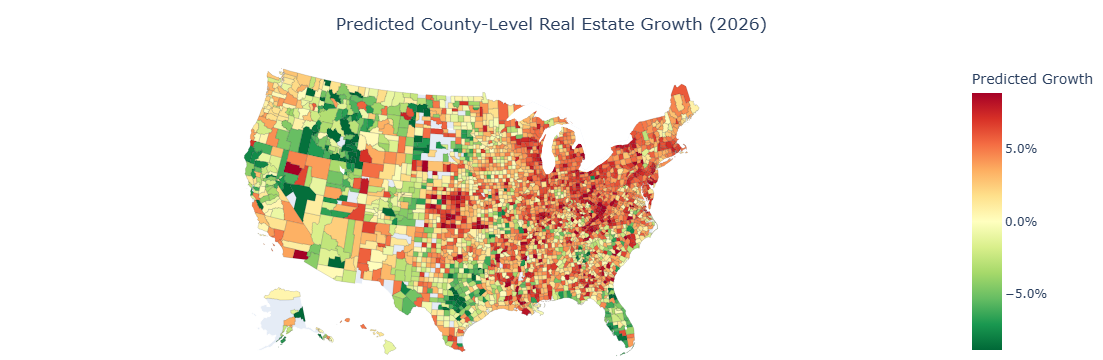

In [33]:
import json
import requests
import numpy as np
import plotly.express as px



# 1) Filter to 2026 and normalize FIPS to 5-char strings
df2026 = pred.loc[pred["year"] == 2026, [county_col, "yhat"]].copy()
if df2026.empty:
    raise ValueError("No rows found for year 2026 in 'pred'.")
df2026[county_col] = df2026[county_col].astype(str).str.zfill(5)

# 2) Load the same GeoJSON from GitHub and build FIPS -> 'County, ST' mapping
GEOJSON_URL = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
gj = requests.get(GEOJSON_URL, timeout=30).json()

# State FIPS -> USPS abbreviation
state_fips_to_abbr = {
    '01':'AL','02':'AK','04':'AZ','05':'AR','06':'CA','08':'CO','09':'CT','10':'DE','11':'DC','12':'FL',
    '13':'GA','15':'HI','16':'ID','17':'IL','18':'IN','19':'IA','20':'KS','21':'KY','22':'LA','23':'ME',
    '24':'MD','25':'MA','26':'MI','27':'MN','28':'MS','29':'MO','30':'MT','31':'NE','32':'NV','33':'NH',
    '34':'NJ','35':'NM','36':'NY','37':'NC','38':'ND','39':'OH','40':'OK','41':'OR','42':'PA','44':'RI',
    '45':'SC','46':'SD','47':'TN','48':'TX','49':'UT','50':'VT','51':'VA','53':'WA','54':'WV','55':'WI','56':'WY'
}

name_map = {}
for feat in gj["features"]:
    fips = feat.get("id")
    props = feat.get("properties", {})
    name = props.get("NAME") or props.get("name") or ""
    state_fips = props.get("STATE") or props.get("state")
    st = state_fips_to_abbr.get(str(state_fips).zfill(2), "")

    # Handle special naming by state
    if state_fips == '22':   # Louisiana
        suffix = "Parish"
    elif state_fips == '02': # Alaska
        suffix = "Borough"   # (Some are Census Areas; this keeps it simple/consistent)
    elif state_fips == '11': # DC
        suffix = ""          # Just "District of Columbia"
    else:
        suffix = "County"

    if name == "District of Columbia":
        label = "District of Columbia, DC"
    else:
        label = f"{name} {suffix}, {st}".strip().replace("  ", " ")

    if fips:
        name_map[fips] = label

# Add readable labels to df2026
df2026["county_label"] = df2026[county_col].map(name_map).fillna(df2026[county_col])

# 3) Robust symmetric color scaling using 2nd–98th percentiles
finite_vals = df2026["yhat"].replace([np.inf, -np.inf], np.nan).dropna()
if finite_vals.empty:
    raise ValueError("All 'yhat' values are NaN/Inf for 2026.")
lo, hi = np.nanpercentile(finite_vals, [2, 98])
vmax = float(max(abs(lo), abs(hi))) if np.isfinite([lo, hi]).all() else float(np.nanmax(np.abs(finite_vals)))
if not np.isfinite(vmax) or vmax == 0:
    vmax = float(np.nanmax(np.abs(finite_vals))) or 1.0

# 4) Choropleth (single, polished 2026 map)
fig = px.choropleth(
    df2026,
    geojson=GEOJSON_URL,
    locations=county_col,                   # FIPS drives geometry
    color="yhat",
    color_continuous_scale=px.colors.diverging.RdYlGn_r,
    range_color=(-vmax, vmax),              # symmetric around 0
    color_continuous_midpoint=0,
    scope="usa",
    labels={"yhat": "Predicted Growth (%)"},
    title="Predicted County-Level Real Estate Growth (2026)",
    custom_data=["county_label"]            # for cleaner hover
)

# Presentation tweaks
fig.update_layout(
    coloraxis_colorbar=dict(title="Predicted Growth", tickformat=".1%"),
    margin=dict(l=0, r=0, t=60, b=0),
    title=dict(x=0.5, xanchor="center")
)
fig.update_traces(
    marker_line_width=0.25,
    marker_line_color="rgba(0,0,0,0.5)",
    hovertemplate="%{customdata[0]}<br>Growth: %{z:.2%}<extra></extra>"
)

fig.show()


In [29]:
# 2026 Map + Exports + Top/Bottom 10 Tables (artifacts folder) 
import os
import json
import requests
import numpy as np
import pandas as pd
import plotly.express as px

#  Ensure artifacts folder exists 
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# "County, ST" map from Plotly GeoJSON 
def build_county_label_map(geojson_url: str):
    state_fips_to_abbr = {
        '01':'AL','02':'AK','04':'AZ','05':'AR','06':'CA','08':'CO','09':'CT','10':'DE','11':'DC','12':'FL',
        '13':'GA','15':'HI','16':'ID','17':'IL','18':'IN','19':'IA','20':'KS','21':'KY','22':'LA','23':'ME',
        '24':'MD','25':'MA','26':'MI','27':'MN','28':'MS','29':'MO','30':'MT','31':'NE','32':'NV','33':'NH',
        '34':'NJ','35':'NM','36':'NY','37':'NC','38':'ND','39':'OH','40':'OK','41':'OR','42':'PA','44':'RI',
        '45':'SC','46':'SD','47':'TN','48':'TX','49':'UT','50':'VT','51':'VA','53':'WA','54':'WV','55':'WI','56':'WY'
    }
    resp = requests.get(geojson_url, timeout=30)
    resp.raise_for_status()
    gj = resp.json()
    name_map = {}
    for feat in gj["features"]:
        fips = feat.get("id")
        props = feat.get("properties", {})
        name = props.get("NAME") or props.get("name") or ""
        state_fips = str(props.get("STATE") or props.get("state") or "").zfill(2)
        st = state_fips_to_abbr.get(state_fips, "")

        if state_fips == '22':
            suffix = "Parish"
        elif state_fips == '02':
            suffix = "Borough"
        elif state_fips == '11':
            suffix = ""
        else:
            suffix = "County"

        if name == "District of Columbia":
            label = "District of Columbia, DC"
        else:
            label = f"{name} {suffix}, {st}".strip().replace("  ", " ")
        if fips:
            name_map[fips] = label
    return name_map

# Build 2026 frame
required = {county_col, "year", "yhat"}
missing = [c for c in required if c not in pred.columns]
if missing:
    raise ValueError(f"Missing required columns in pred: {missing}")

df2026 = pred.loc[pred["year"] == 2026, [county_col, "yhat"]].copy()
if df2026.empty:
    raise ValueError("No rows found for 2026.")

df2026[county_col] = df2026[county_col].astype(str).str.zfill(5)

# Add labels from GeoJSON
GEOJSON_URL = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
name_map = build_county_label_map(GEOJSON_URL)
df2026["county_label"] = df2026[county_col].map(name_map).fillna(df2026[county_col])

# Symmetric color scaling 
finite_vals = df2026["yhat"].replace([np.inf, -np.inf], np.nan).dropna()
lo, hi = np.nanpercentile(finite_vals, [2, 98])
vmax = float(max(abs(lo), abs(hi))) if np.isfinite([lo, hi]).all() else float(np.nanmax(np.abs(finite_vals)))
if not np.isfinite(vmax) or vmax == 0:
    vmax = float(np.nanmax(np.abs(finite_vals))) or 1.0

#Choropleth
fig = px.choropleth(
    df2026,
    geojson=GEOJSON_URL,
    locations=county_col,
    color="yhat",
    color_continuous_scale=px.colors.diverging.RdYlGn_r,
    range_color=(-vmax, vmax),
    color_continuous_midpoint=0,
    scope="usa",
    labels={"yhat": "Predicted Growth (%)"},
    title="Predicted County-Level Real Estate Growth (2026)",
    custom_data=["county_label"]
)
fig.update_layout(
    coloraxis_colorbar=dict(title="Predicted Growth", tickformat=".1%"),
    margin=dict(l=0, r=0, t=60, b=0),
    title=dict(x=0.5, xanchor="center")
)
fig.update_traces(
    marker_line_width=0.25,
    marker_line_color="rgba(0,0,0,0.5)",
    hovertemplate="%{customdata[0]}<br>Growth: %{z:.2%}<extra></extra>"
)

#Save PNG + HTML in artifacts
png_path = os.path.join(ARTIFACTS_DIR, "growth_2026.png")
html_path = os.path.join(ARTIFACTS_DIR, "growth_2026.html")

try:
    fig.write_image(png_path, scale=3, width=1200, height=750)
    print(f"Saved: {png_path}")
except Exception as e:
    print("PNG export failed. Install kaleido via: pip install -U kaleido")
    print(f"Error: {e}")

fig.write_html(html_path, include_plotlyjs="cdn")
print(f"Saved: {html_path}")

# -------- Top / Bottom 10 tables + CSV --------
df_show = df2026[["county_label", "yhat"]].copy().sort_values("yhat", ascending=False)

top10 = df_show.head(10).copy()
bot10 = df_show.tail(10).copy()

def _fmt_pct(s): return (s*100).round(2).astype(str) + "%"

print("\nTop 10 Counties by Predicted Growth (2026):")
display(top10.assign(Predicted_Growth=_fmt_pct(top10["yhat"]))[["county_label", "Predicted_Growth"]])

print("\nBottom 10 Counties by Predicted Growth (2026):")
display(bot10.assign(Predicted_Growth=_fmt_pct(bot10["yhat"]))[["county_label", "Predicted_Growth"]])

top_path = os.path.join(ARTIFACTS_DIR, "top10_2026.csv")
bot_path = os.path.join(ARTIFACTS_DIR, "bottom10_2026.csv")
top10.to_csv(top_path, index=False)
bot10.to_csv(bot_path, index=False)
print(f"Saved: {top_path}, {bot_path}")

# -------- National average --------
national_avg = float(df2026["yhat"].mean())
print(f"\nNational average predicted growth (2026): {national_avg:.2%}")


Saved: artifacts\growth_2026.png
Saved: artifacts\growth_2026.html

Top 10 Counties by Predicted Growth (2026):


,county_label,Predicted_Growth
6301,"Imperial County, CA",15.32%
7511,"Coahoma County, MS",13.97%
7845,"Pershing County, NV",13.25%
7059,"Pawnee County, KS",12.5%
6723,"Gallatin County, IL",12.06%
7822,"Sheridan County, NE",11.91%
9039,"Fayette County, WV",11.76%
7114,"Casey County, KY",11.65%
7036,"Labette County, KS",11.4%
7079,"Stafford County, KS",11.35%



Bottom 10 Counties by Predicted Growth (2026):


,county_label,Predicted_Growth
6687,"Payette County, ID",-11.3%
6661,"Boundary County, ID",-12.32%
6668,"Custer County, ID",-12.59%
7674,"Schuyler County, MO",-12.85%
9168,"Lincoln County, WY",-13.47%
7703,"Fallon County, MT",-14.21%
8809,"Williamson County, TX",-14.47%
6682,"Madison County, ID",-15.04%
8438,"Butte County, SD",-15.55%
8790,"Travis County, TX",-17.22%


Saved: artifacts\top10_2026.csv, artifacts\bottom10_2026.csv

National average predicted growth (2026): 2.23%


In [7]:

!pip install -U "plotly>=6.1.1" kaleido


In [9]:
import plotly, kaleido
print(plotly.__version__)   # should be 6.1.1+
out_png = "artifacts/map_2026.png"
fig.write_image(out_png, scale=2)
print("Saved:", out_png)


6.3.0
Saved: artifacts/map_2026.png


In [35]:
# === Top 10 Bar Chart (saved to artifacts) ===
import os
import numpy as np
import pandas as pd
import plotly.express as px

ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Reuse existing top10 if available; otherwise rebuild from df2026
if "top10" not in globals():
    if "df2026" not in globals():
        raise RuntimeError("df2026 not found. Run the 2026 map block first.")
    df_show = df2026[["county_label", "yhat"]].copy().sort_values("yhat", ascending=False)
    top10 = df_show.head(10).copy()

# For a clean label ordering (descending)
top10_plot = top10.sort_values("yhat", ascending=True)  # ascending for horizontal bar (smallest at top)

fig_bar = px.bar(
    top10_plot,
    x="yhat",
    y="county_label",
    orientation="h",
    labels={"yhat": "Predicted Growth (%)", "county_label": ""},
    title="Top 10 Counties by Predicted Real Estate Growth (2026)",
    text=top10_plot["yhat"].map(lambda v: f"{v:.2%}")  # on-bar percent labels
)

# Polished layout: percent axis ticks, margin for long labels
fig_bar.update_layout(
    xaxis=dict(tickformat=".1%"),
    margin=dict(l=160, r=40, t=70, b=40),
    title=dict(x=0.5, xanchor="center")
)
fig_bar.update_traces(
    textposition="outside",
    cliponaxis=False
)

# Save PNG + HTML
bar_png = os.path.join(ARTIFACTS_DIR, "top10_bar_2026.png")
bar_html = os.path.join(ARTIFACTS_DIR, "top10_bar_2026.html")
try:
    fig_bar.write_image(bar_png, scale=3, width=1100, height=650)
    print(f"Saved: {bar_png}")
except Exception as e:
    print("PNG export failed. Install kaleido via: pip install -U kaleido")
    print(f"Error: {e}")

fig_bar.write_html(bar_html, include_plotlyjs="cdn")
print(f"Saved: {bar_html}")


Saved: artifacts\top10_bar_2026.png
Saved: artifacts\top10_bar_2026.html


In [37]:
# === Bottom 10 Bar Chart (saved to artifacts) ===
import os
import numpy as np
import pandas as pd
import plotly.express as px

ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Reuse existing bot10 if available; otherwise rebuild from df2026
if "bot10" not in globals():
    if "df2026" not in globals():
        raise RuntimeError("df2026 not found. Run the 2026 map block first.")
    # Build bottom 10 from scratch to avoid ordering surprises
    df_show = df2026[["county_label", "yhat"]].copy()
    bot10 = df_show.sort_values("yhat", ascending=True).head(10).copy()

# For a clean horizontal plot with the *lowest* at the top
bot10_plot = bot10.sort_values("yhat", ascending=True)

fig_bar_bot = px.bar(
    bot10_plot,
    x="yhat",
    y="county_label",
    orientation="h",
    labels={"yhat": "Predicted Growth (%)", "county_label": ""},
    title="Bottom 10 Counties by Predicted Real Estate Growth (2026)",
    text=bot10_plot["yhat"].map(lambda v: f"{v:.2%}")
)

# Polished layout: percent ticks, extra left margin for long names
fig_bar_bot.update_layout(
    xaxis=dict(tickformat=".1%"),
    margin=dict(l=180, r=40, t=70, b=40),
    title=dict(x=0.5, xanchor="center")
)
fig_bar_bot.update_traces(
    textposition="outside",
    cliponaxis=False
)

# Save PNG + HTML
bot_bar_png = os.path.join(ARTIFACTS_DIR, "bottom10_bar_2026.png")
bot_bar_html = os.path.join(ARTIFACTS_DIR, "bottom10_bar_2026.html")
try:
    fig_bar_bot.write_image(bot_bar_png, scale=3, width=1100, height=650)
    print(f"Saved: {bot_bar_png}")
except Exception as e:
    print("PNG export failed. Install kaleido via: pip install -U kaleido")
    print(f"Error: {e}")

fig_bar_bot.write_html(bot_bar_html, include_plotlyjs="cdn")
print(f"Saved: {bot_bar_html}")


Saved: artifacts\bottom10_bar_2026.png
Saved: artifacts\bottom10_bar_2026.html
